In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import os
from unidecode import unidecode


C:\Users\mateo\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\mateo\miniconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\mateo\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


# ENGE pre 2016

In [3]:
#cargo y limpio data
vab_1 = pd.read_csv('./enge - producto.csv', skiprows=2)
emp_1 = pd.read_csv('./enge - empleo.csv', skiprows=2)
# emp_1 = emp_1.replace('.', '', regex=True)


def replace_points(df):
    # Iterate over each column
    for col in df.columns:
        if df[col].dtype == 'float':
            df[col] = df[col].astype(str).str.replace('.', '').astype(int)
            
    return df

def clean_col (df, col):
    df = df.replace(',', '', regex=True)

    df.columns = [ x.replace('  ', '').replace('\n', '').strip() for x in  df.columns]
        
    # Get the current column names
    # column_names = df.columns.tolist()
    # # print(column_names)
    # # Specify the index of the column you want to rename
    # column_index = 0
    # # Set the new column name at the specified index
    # column_names[column_index] = 'year'
    # Update the column names in the DataFrame
    # df.columns = column_names

    print(df.columns)
    
    df = df.melt(id_vars = 'year')

    df.rename(columns = {'value': col,
                        'variable': 'sector',
                        }, inplace = True)
    
    print(f'unque sectors: {len(df.sector.unique())}')
    
    #filtro año 2016 pero habria q buscarlo
    df = df[df['year'] < 2016]
    
    df[col] = df[col].astype(float) if col == 'vab' else df[col].astype(int)
    
    return df


# emp_1 = replace_points(emp_1)#

    
emp_1 = clean_col(emp_1, 'emp')
vab_1 = clean_col(vab_1, 'vab')

print(emp_1.info(), vab_1.info() )


Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    253 non-null    int64 
 1   sector  253 non-null    object
 2   emp     253 non-null    int32 
dtypes: int3

In [4]:
#joineo
data_1 = pd.merge(vab_1,
         emp_1,
         how = 'left', 
         on = ['year', 'sector'])

data_1['sector'] = data_1['sector'].apply(unidecode)

len(data_1.sector.unique())

11

In [5]:
# data_1['productividad'] = data_1.vab/data_1.emp
# data_1

# ENGE post 2016

In [6]:
#cargo data

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

# List files in the current directory
def get_enge_data_2(current_directory):
    files = os.listdir(current_directory)
    data = pd.DataFrame()
    total_len = 0
    for file in files:
        if '.xls' in file: 
            # print(file)
            year = file.split('.')[0].split('_')[-1].strip()
            # print(year)
            # Specify the file path
            file_path =  current_directory + "/" + file

            # Specify the sheet name or index
            sheet_name = 'C11'  # You can also use the sheet index (0, 1, 2, etc.)

            # Read the Excel file
            df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows  = 2)


            # Rename the columns starting with 'Unnamed'
            df.rename(columns=lambda x: df.iloc[0][x] if 'Unnamed' in str(x) else x, inplace=True)
            df.rename(columns={'Componente': 'componente', 
                               'Unidad de medida': 'unidad',
                    'Electricidad, gas, agua, residuos y saneamiento' : 'Electricidad, gas y agua',
                    'Servicios de información y comunicaciones': 'Comunicaciones',
                    'Industria manufacturera': 'Total Manufactura'
                    }, inplace = True)
            
            # Drop the first two rows
            df = df.drop([0, 1]).reset_index(drop=True)

            
            df = df.melt(id_vars = ['componente', 'unidad'], var_name = 'sector')

            # Filter rows that start with "Fuente"
            df.dropna(subset = ['componente'], inplace = True)
            df = df[~df['componente'].str.startswith('Fuente')  & df['componente'].notna()]

            df['year']= year    

            total_len += len(df)

            data = pd.concat([df, data])

    print(total_len)
    return data
data = get_enge_data_2(current_directory)
data.info()

Current directory: C:\Users\mateo\Documents\repos\productivity_measures\enge
1050
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 237
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   componente  1050 non-null   object
 1   unidad      1050 non-null   object
 2   sector      1050 non-null   object
 3   value       1050 non-null   object
 4   year        1050 non-null   object
dtypes: object(5)
memory usage: 49.2+ KB


In [7]:
#calculo el index 

def get_index(df):
    # print(df.columns)
    # Pivot the dataframe
    pivot_df = df.pivot(values='value', index=['sector', 'year'], columns='componente')#.reset_index()#.drop(['componente'], axis =1)
    

    # Calculate the ratio
    # pivot_df['productividad'] = pivot_df['Valor agregado bruto'] / pivot_df['Puestos de trabajo asalariados']
    pivot_df['tasa_rentabilidad'] = pivot_df['Utilidad'] / pivot_df['Activo'] *100

    pivot_df.rename(columns = {'Valor agregado bruto': 'vab',
                              'Puestos de trabajo asalariados' : 'emp',
                              }, inplace = True)
    
    # print(pivot_df.columns)
    pivot_df.reset_index(inplace= True)
    pivot_df = pivot_df[['year', 'sector', 'vab' , 'emp' ]] # 'productividad'
    
    pivot_df['sector'] = pivot_df['sector'].apply(unidecode)

    return pivot_df.reset_index()
data_2  = get_index(data)

In [8]:
data_2.head(3)
# data_2.reset_index()
# data_2.index#iloc[:,1: ]#.index

componente,index,year,sector,vab,emp
0,0,2017,"Alimentos, bebidas y tabaco",318010.524911,137557
1,1,2018,"Alimentos, bebidas y tabaco",526944.771732,133637
2,2,2019,"Alimentos, bebidas y tabaco",787440.418027,130560


In [9]:
#veo los sectores presentes en cada conjunto de datos
dict_sectors = {}
for df_i, nam_i in zip([data_1, data_2 ], ['data_1', 'data_2']):
    unique_sectors = df_i.sector.unique()
    print(nam_i)
    # print(unique_sectors)
    print(len(unique_sectors))

    dict_sectors[nam_i] = unique_sectors
    
dict_sectors


data_1
11
data_2
16


{'data_1': array(['Total', 'Minas y canteras', 'Total Manufactura',
        'Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos',
        'Maquinarias, equipos y vehiculos', 'Resto industria (1)',
        'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
        'Resto actividades (2)'], dtype=object),
 'data_2': array(['Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos', 'Comercio', 'Comunicaciones',
        'Construccion', 'Electricidad, gas y agua',
        'Maquinarias, equipos y vehiculos', 'Minas y canteras',
        'Minerales no metalicos, metales y productos de metal',
        'Otras actividades', 'Otros industria manufacturera',
        'Textiles y cuero', 'Textiles y cueros', 'Total',
        'Total Manufactura', 'Transporte, correo y almacenamiento'],
       dtype=object)}

In [10]:
#veo los sectores en comun
set1 = set(dict_sectors['data_1'])
set2 = set(dict_sectors['data_2'])

common_values = set1.intersection(set2)
print(len(common_values))
# common_values = common_values.astype(list)
print(type(common_values))
common_values

8
<class 'set'>


{'Alimentos, bebidas y tabaco',
 'Combustibles, quimicos y plasticos',
 'Comunicaciones',
 'Electricidad, gas y agua',
 'Maquinarias, equipos y vehiculos',
 'Minas y canteras',
 'Total',
 'Total Manufactura'}

In [11]:
#concateno la data y me quedo con los sectores en comun
data = pd.concat([data_1, data_2 ])
# Apply unidecode to all string columns
# data = data.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)

# Replace 'unique' with 'Resto industria' if not in common_values
data['sector'] = np.where(data['sector'].isin(common_values), data['sector'], 'Resto industria')
data['year'] = data['year'].astype(int)

unique_sectors = data.sector.unique()
print(unique_sectors)
print(len(unique_sectors))

['Total' 'Minas y canteras' 'Total Manufactura'
 'Alimentos, bebidas y tabaco' 'Combustibles, quimicos y plasticos'
 'Maquinarias, equipos y vehiculos' 'Resto industria'
 'Electricidad, gas y agua' 'Comunicaciones']
9


In [12]:
#agrego el resto de la industria
data_agg = data.groupby(['year', 'sector']).agg(
    {'vab': 'sum',
     'emp': 'sum',
     # 'productividad': 'mean'
    }

    ).reset_index()

In [13]:
#cargo indices de precios y tcp
indices =  pd.read_excel('../data/TCP_me.xlsx', skiprows  = 2)
# print(indices)
indices.rename(columns = {
    'Unnamed: 0' : 'year',
    'Unnamed: 14' : 'index_TCP_1',
    'Unnamed: 15' : 'index_TCP_2',
    'TCC' : 'TCC_old',
    'TCC.1' : 'TCC'
        },
               inplace = True
              )
indices = indices.iloc[2:, :]
indices = indices[['year', 'IPC', 'TCC', 'index_TCP_1', 'index_TCP_2']]
indices['TCP_1'] = indices['TCC'] * indices['index_TCP_1'] 
indices['TCP_2'] = indices['TCC'] * indices['index_TCP_2'] 
indices['year'] = indices['year'].astype(int) #astype(str).str.strip(). 
# indices.year.tolist()

In [14]:
ipi_df = pd.read_csv('../data/IPI.csv', skiprows  = 4)
ipi_df.columns = ['year', 'ipi_base2004', 'ipi_base93_93', 'ipi_base93_04', 'ipi_empalme_04']
ipi_df = ipi_df[['year','ipi_empalme_04']]

In [15]:
def get_index(df, name_var, base_year, index_bool = True):
    # df[name_var] = df[production]/df[work]
    
    if index_bool:
        name_index = name_var + '_index'
        base_year= base_year
        
        # calculate the base productivity for each country
        base_prod =pd.DataFrame(df.loc[df['year'] == base_year, [name_var, 'sector'] ].groupby('sector').first()).reset_index()
        # print(base_prod)
        base_prod.columns = [  'sector', 'productivity_base']
        df = pd.merge(df.reset_index(), base_prod, how = 'left', left_on='sector', right_on='sector')
        df[name_index] = df[name_var] / df['productivity_base'] 
        df.drop('productivity_base', axis =  1, inplace = True)
        
        return df[name_index]



In [16]:
data_join = pd.merge(data_agg,
         indices,
         how = 'left',
         on = 'year')

data_join = pd.merge(data_join,
         ipi_df,
         how = 'left',
         on = 'year')


data_join['vab'] = data_join['vab'] # * 10e6
data_join['ipi_empalme_04'] = data_join['ipi_empalme_04'] / 100

data_join['vab_ipc'] = data_join['vab'] /data_join['IPC']
data_join['vab_ipi'] = data_join['vab'] /data_join['ipi_empalme_04']
data_join['vab_tcp_1'] = data_join['vab']/data_join['TCP_1']
data_join['vab_tcc'] = data_join['vab']/data_join['TCC']

data_join['vab_ipi_index'] = get_index(data_join, 'vab_ipi', 1997)
data_join['emp_index'] = get_index(data_join, 'emp', 1997)


data_join['productividad_ipc_level'] = data_join['vab_ipc']/data_join['emp']
data_join['productividad_ipi_level'] = data_join['vab_ipi']/data_join['emp']
data_join['productividad_tcp_1_level'] = data_join['vab_tcp_1']/data_join['emp']
data_join['productividad_tcc_level'] = data_join['vab_tcc']/data_join['emp']

data_join['productividad_ipi_index_1'] = data_join['vab_ipi_index']/data_join['emp_index']
# data_join['productividad_ipi_index_2'] = get_index(data_join, 'productividad_ipi_level', 1997)

#unidades
## vab = pesos corrientes
## emp = puestos de trabajo asalariados (cantidad)
## IPC = base 2004=1
## index_TCP_1 = nivel de sobrevaluacion ipi + ipc
## index_TCP_1 = nivel de sobrevaluacion ipc
## TCP = TCC * index_TCP
data_join.to_csv('../results/enge_results.csv', sep=';', decimal='.')
data_join.to_excel("../results/enge_results.xlsx") 

In [17]:
pd.set_option('display.max_columns', None)
data_join.tail()

,year,sector,vab,emp,IPC,TCC,index_TCP_1,index_TCP_2,TCP_1,TCP_2,ipi_empalme_04,vab_ipc,vab_ipi,vab_tcp_1,vab_tcc,vab_ipi_index,emp_index,productividad_ipc_level,productividad_ipi_level,productividad_tcp_1_level,productividad_tcc_level,productividad_ipi_index_1
247,2021,"Maquinarias, equipos y vehiculos",4.408243e+05,49836.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,6788.087352,7132.385443,2434.521208,4635.70585,1.547965,1.195825,0.136209,0.143117,0.048851,0.093019,1.294474
248,2021,Minas y canteras,1.316020e+06,44224.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,20264.901504,21292.756118,7267.928348,13839.262458,2.252579,3.710690,0.458233,0.481475,0.164344,0.312936,0.607051
249,2021,Resto industria,1.641216e+06,372674.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,25272.469623,26554.312740,9063.873237,17259.019986,0.508430,0.719458,0.067814,0.071253,0.024321,0.046311,0.706685
250,2021,Total,7.398317e+06,783984.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,113923.887408,119702.212723,40858.360484,77800.653398,1.490474,1.431722,0.145314,0.152685,0.052116,0.099238,1.041036
251,2021,Total Manufactura,3.873366e+06,294295.0,64.940875,95.09325,1.904155,1.159401,181.072292,110.25124,61.806017,59644.492859,62669.716900,21391.266095,40732.287333,1.591278,1.104408,0.202669,0.212949,0.072686,0.138406,1.440842


Text(0.5, 1.0, 'Line Plot of IPI by Year')

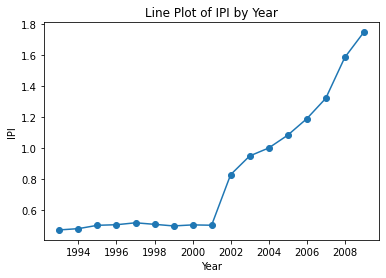

In [18]:
data_ipi = data_join.loc[data_join['year']<2010, ['year', 'ipi_empalme_04']].drop_duplicates()
# Create the line plot
plt.plot(data_ipi['year'], data_ipi['ipi_empalme_04'], marker='o')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('IPI')
plt.title('Line Plot of IPI by Year')

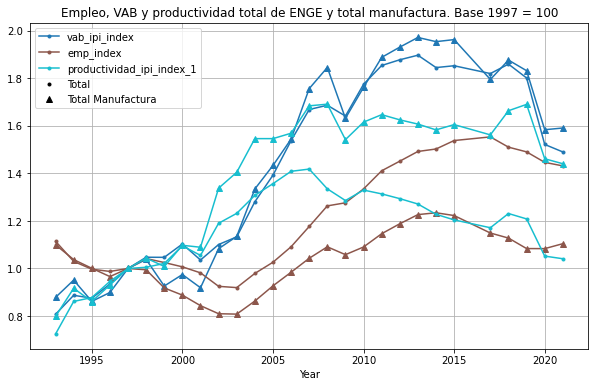

In [19]:
sectors = ['Total',    'Total Manufactura'] # 'Minas y canteras',

df_sel_index = data_join.loc[data_join['sector'].isin(sectors), ['year', 'sector',  'vab_ipi_index', 'emp_index',
                                                                 'productividad_ipi_index_1', ]] # 'ipi_empalme_04',


# Extract variables for plotting
x = df_sel_index['year']
y_vars = df_sel_index.columns[2:]  # Select all columns except 'year' and 'sector'
sectors = df_sel_index['sector'].unique()

# Create a color map for the variables
colors = plt.cm.get_cmap('tab10', len(y_vars))
markers = ['.', '^']

# Create the line plot
plt.figure(figsize=(10, 6))
for i, var in enumerate(y_vars):
    for j, sector in enumerate(sectors):
        df_sector = df_sel_index[df_sel_index['sector'] == sector]
        plt.plot(df_sector['year'], df_sector[var], color=colors(i), marker=markers[j], label=var if j == 0 else None)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('')
title = 'Empleo, VAB y productividad total de ENGE y total manufactura. Base 1997 = 100'
plt.title(title)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in markers])
labels.extend(sectors)
plt.legend(handles, labels)

plt.grid(True)  # Add a grid
plt.savefig('../results/' + title + '.png')
# Show the plot
plt.show()

In [20]:
data_join['sector'].unique()

array(['Alimentos, bebidas y tabaco',
       'Combustibles, quimicos y plasticos', 'Comunicaciones',
       'Electricidad, gas y agua', 'Maquinarias, equipos y vehiculos',
       'Minas y canteras', 'Resto industria', 'Total',
       'Total Manufactura'], dtype=object)

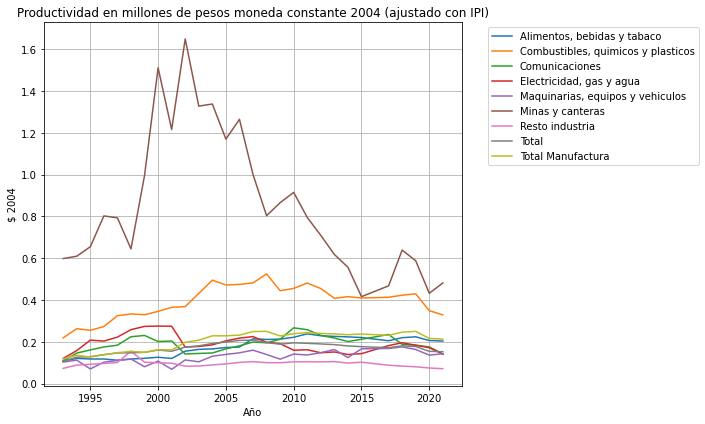

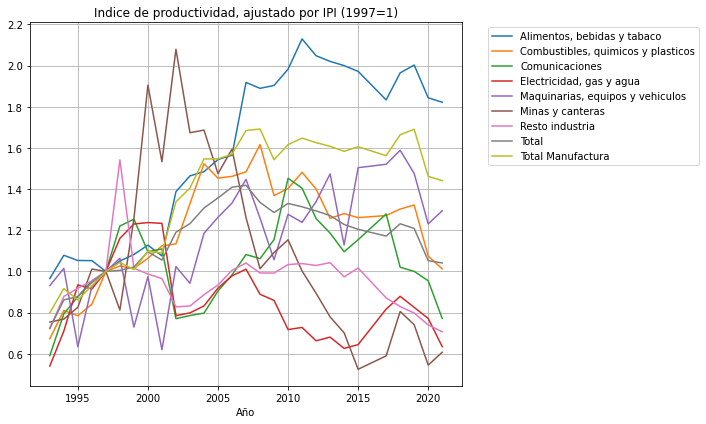

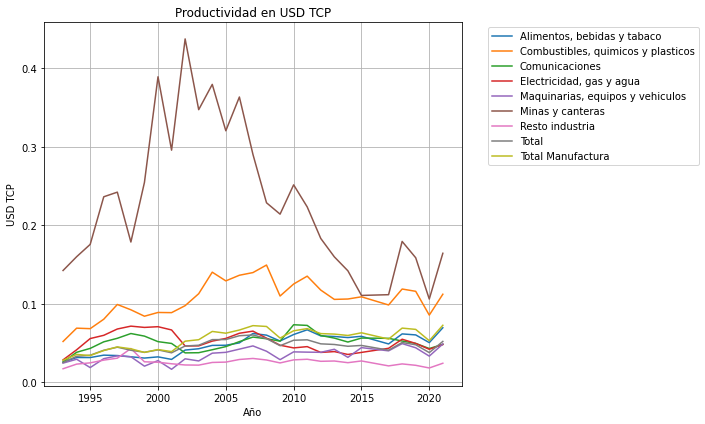

In [21]:
sectors = ['Total',    'Total Manufactura'] # 'Minas y canteras',
# data_plot = data_join[data_join['sector'].isin(sectors)]
# data_plot = data_join[data_join['sector'] != 'Minas y canteras' ]
data_plot = data_join

for variable, title, axis_y in zip(['productividad_ipi_level', 'productividad_ipi_index_1',  'productividad_tcp_1_level'], 
                                   ['Productividad en millones de pesos moneda constante 2004 (ajustado con IPI)',  'Indice de productividad, ajustado por IPI (1997=1)', 'Productividad en USD TCP' ], 
                                   ['$ 2004', '',  'USD TCP']):
    

    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

    # Group the data by sector and plot each group separately
    for sector, data in data_plot.groupby('sector'):
        plt.plot(data['year'], data[variable], label=sector)

    plt.xlabel('Año')
    plt.ylabel(axis_y)
    plt.title(title)
    # plt.legend()  # Show the legend with sector labels
    # Place the legend outside the plot on the right side
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)  # Add a grid
    # Adjust the layout of the figure to accommodate the legend
    plt.tight_layout()
    plt.savefig('../results/' + title + '.png')

    plt.show()
    
    

## Brecha productividaddata_join

In [22]:
data_tot = pd.read_csv('../data/va_manuf_arg.csv', skiprows=3)
data_tot = data_tot[['year',  'vab_tot_04', 'emp_tot', 'productividad_manuf_97'  ]]
data_tot = data_tot.replace(',', '', regex=True)
data_tot['vab_tot_04'] = data_tot['vab_tot_04'].astype(int)
data_tot['productividad_manuf_97'] = data_tot['productividad_manuf_97'] / 100
data_tot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    30 non-null     int64  
 1   vab_tot_04              30 non-null     int32  
 2   emp_tot                 30 non-null     int64  
 3   productividad_manuf_97  30 non-null     float64
dtypes: float64(1), int32(1), int64(2)
memory usage: 968.0 bytes


In [23]:
data_enge = data_join.loc[data_join['sector']=='Total Manufactura', ['year',  'emp','vab_ipi',  'productividad_ipi_index_1' ]]

In [24]:
data_join2  = pd.merge(data_enge,
         data_tot,
         how = 'left',
         on = 'year')

data_join2['sector'] = 'Total Manufactura sin ENGE'

data_join2['vab_sin_enge'] =  data_join2['vab_tot_04'] - data_join2['vab_ipi']
data_join2['emp_sin_enge'] = data_join2['emp_tot'] - data_join2['emp']

data_join2['vab_sin_enge_index'] = get_index(data_join2, 'vab_sin_enge', 1997)
data_join2['emp_sin_enge_index'] = get_index(data_join2, 'emp_sin_enge', 1997)

data_join2['productividad_sin_enge_index'] = data_join2['vab_sin_enge_index']/data_join2['emp_sin_enge_index']

data_join2['peso_vab_enge'] = data_join2['vab_ipi']/ data_join2['vab_tot_04'] 
data_join2['peso_emp_enge'] = data_join2['emp']/ data_join2['emp_tot'] 

data_join2.head(3)


,year,emp,vab_ipi,productividad_ipi_index_1,vab_tot_04,emp_tot,productividad_manuf_97,sector,vab_sin_enge,emp_sin_enge,vab_sin_enge_index,emp_sin_enge_index,productividad_sin_enge_index,peso_vab_enge,peso_emp_enge
0,1993,293052.0,34599.858995,0.798861,91639,2128972,0.753,Total Manufactura sin ENGE,57039.141005,1835920.0,0.937346,1.234429,0.759336,0.377567,0.137650
1,1994,276471.0,37459.116384,0.916747,95045,1947301,0.854,Total Manufactura sin ENGE,57585.883616,1670830.0,0.946331,1.123426,0.842362,0.394120,0.141977
2,1995,266714.0,33935.169539,0.860886,87574,1777968,0.862,Total Manufactura sin ENGE,53638.830461,1511254.0,0.881468,1.016131,0.867474,0.387503,0.150011


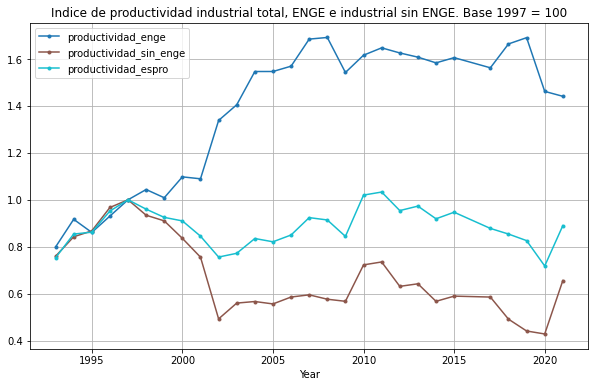

In [25]:
# df_sel_index = data_join2[['year', 'sector',  'productividad_ipi_index_1', 'vab_sin_enge_index', 'emp_sin_enge_index',   'productividad_sin_enge_index', 'productividad_manuf_97']]
df_sel_index = data_join2[['year', 'sector',  'productividad_ipi_index_1',  'productividad_sin_enge_index', 'productividad_manuf_97']]
df_sel_index.columns = ['year', 'sector',  'productividad_enge',  'productividad_sin_enge', 'productividad_espro']

title = 'Indice de productividad industrial total, ENGE e industrial sin ENGE. Base 1997 = 100'

# Extract variables for plotting
x = df_sel_index['year']
y_vars = df_sel_index.columns[2:]  # Select all columns except 'year' and 'sector'
sectors = df_sel_index['sector'].unique()

# Create a color map for the variables
colors = plt.cm.get_cmap('tab10', len(y_vars))
markers = ['.']

# Create the line plot
plt.figure(figsize=(10, 6))
for i, var in enumerate(y_vars):
    for j, sector in enumerate(sectors):
        df_sector = df_sel_index[df_sel_index['sector'] == sector]
        plt.plot(df_sector['year'], df_sector[var], color=colors(i), marker=markers[j], label=var if j == 0 else None)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('')
plt.title(title)

# Add a legend
handles, labels = plt.gca().get_legend_handles_labels()
# handles.extend([plt.Line2D([], [], color='black', marker=marker, linestyle='None') for marker in markers])
labels.extend(sectors)
plt.legend(handles, labels)

plt.grid(True)  # Add a grid

plt.savefig('../results/' + title + '.png')
# Show the plot
plt.show()


In [26]:
data_join2.columns = ['year', 'emp_enge', 'vab_ipi_enge',  'productividad_ipi_enge_index_1',
                      'vab_ipi_tot_manuf', 'emp_tot_manuf', 'productividad_tot_manuf_index',
                      'sector',
                      'vab_ipi_sin_enge', 'emp_sin_enge', 'vab_ipi_sin_enge_index', 'emp_sin_enge_index', 'productividad_sin_enge_index',
                      'peso_vab_enge', 'peso_emp_enge']
data_join2.to_excel("../results/enge_y_total.xlsx") 


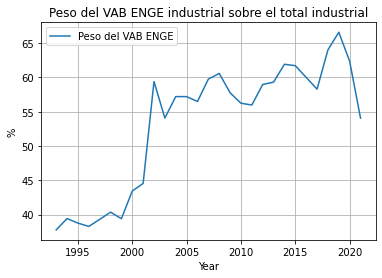

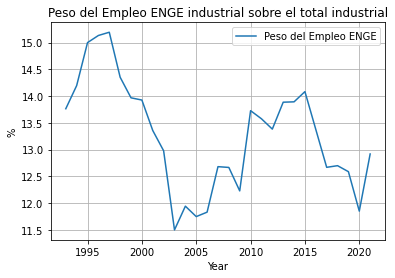

In [31]:
data_peso_plot = data_join2[['year', 'peso_vab_enge', 'peso_emp_enge']]

year = data_peso_plot['year']
peso_vab_enge = data_peso_plot['peso_vab_enge'] *100
peso_emp_enge = data_peso_plot['peso_emp_enge'] *100

for  var, label in zip([peso_vab_enge, peso_emp_enge], ['Peso del VAB ENGE', 'Peso del Empleo ENGE']):
    # Create the line plot
    plt.plot(year, var, label=label)
    # plt.plot(year, peso_emp_enge, label='Peso Emp ENGE')

    plt.xlabel('Year')
    plt.ylabel('%')
    title = f'{label} industrial sobre el total industrial'
    plt.title(title)

    plt.legend()
    plt.grid(True)
    plt.savefig('../results/' + title + '.png')

    plt.show()

In [28]:
# df_sel_index = data_join2[['year', 'sector',  'peso_vab_enge',  'peso_emp_enge']

In [29]:
eeuu_prod = pd.read_csv('../data/eeuu_prod.csv', skiprows = 4)
eeuu_prod.columns =['year', 'prod_arg', 'prod_eeuu', 'brecha']
eeuu_prod.head(3)

,year,prod_arg,prod_eeuu,brecha
0,1973,40.20,46.94,NaN
1,1974,39.91,46.33,19.5
2,1975,37.13,49.17,17.1
